## Анализ результатов A-A-B теста

In [1]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt

import pingouin as pg
import scipy.stats as st 
from tqdm.auto import tqdm

### Задача
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

1. Был ли эксперимент успешен в целом.
2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

### Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

#### users_*.csv – информация о пользователях:

+ uid – идентификатор пользователя
+ age – возраст
+ attraction_coeff – коэффициент привлекательности (от 0 до 1000, 1000*{лайки}/{просмотры}
+ coins – число монеток (внутренняя валюта)
+ country – страна  
+ visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
+ gender – пол
+ age_filter_start  – фильтр поиска, мин. значение 
+ age_filter_end  – фильтр поиска, макс. значение 
+ views_count – число полученных оценок 
+ was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
+ is_premium –  является ли премиум
+ total_revenue – нормированная выручка
 
#### transactions_*.csv – информация о платежах пользователей:

+ uid – идентификатор пользователя
+ country – страна
+ joined_at – дата и время регистрации
+ paid_at – дата и время покупки
+ revenue – нормированная выручка
+ payment_id – идентификатор платежа
+ from_page – откуда пользователь перешел на страницу оплаты
+ product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

### Загрузим данные

In [2]:
# создадим функцию для получения url загрузки и загрузим данные

In [3]:
def get_url (public_key):
    """"Чтобы получить URL для непосредственной загрузки файла, необходимо передать путь на Яндекс Диске,
    по которому загруженный файл должен быть доступен"""
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
users_test             = pd.read_csv(get_url('https://disk.yandex.ru/d/L8HxRYDn2l4h9A'), sep = ';')
users_control_1        = pd.read_csv(get_url('https://disk.yandex.ru/d/TxOD_JxnkMd4mA'), sep = ';')
users_control_2        = pd.read_csv(get_url('https://disk.yandex.ru/d/YT6OWRK2cTWfLg'), sep = ';')
transactions_test      = pd.read_csv(get_url('https://disk.yandex.ru/d/3viYBnm7cyihkQ'), sep = ';',
                                    parse_dates = ['joined_at','paid_at'])
transactions_control_1 = pd.read_csv(get_url('https://disk.yandex.ru/d/84jzzJeQ4tqVyg'), sep = ';',
                                    parse_dates = ['joined_at','paid_at'])
transactions_control_2 = pd.read_csv(get_url('https://disk.yandex.ru/d/_pOo7mrDCZZMyA'), sep = ';',
                                    parse_dates = ['joined_at','paid_at'])

In [5]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [6]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


### Предварительный анализ данных

In [7]:
# объеденим датасеты для более удобного предварительного анализа
# для этого создадим в датасетах стоблцы с информацией о группе

In [8]:
users_test['group']      = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'

In [9]:
users = pd.concat([users_test, users_control_1, users_control_2], axis = 0)

In [10]:
transactions_test['group']      = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'

In [11]:
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2], axis = 0)

In [12]:
# проверим уникальны ли все пользователи

In [13]:
users.shape

(12912, 14)

In [14]:
users.uid.nunique()

12912

In [15]:
# проверим пропущенные значения

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12912 entries, 0 to 4263
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             170 non-null    float64
 4   country           12912 non-null  object 
 5   visit_days        8894 non-null   object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       1255 non-null   float64
 11  is_premium        540 non-null    float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
dtypes: float64(3), int64(8), object(3)
memory usage: 1.5+ MB


Есть пропущенные значения в колонках coins,visit_days, was_premium, is_premium. 
1. coins - количество монет - пропущенные значения можно заменить на ноль
2. visit_days - дни в которые пользователь вернулся,значения объект, заменим на 'no'
3. was_premium, is_premium - пропущенные значения заменим на ноль - наличие премиема будет 1 отсуствие 0

In [17]:
users[['coins','was_premium','is_premium']] = users[['coins','was_premium','is_premium']].fillna(0)
users['visit_days'] = users['visit_days'].fillna('no')

In [18]:
# посмотрим бегло статистику

In [19]:
users.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,1.291200e+04,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000,12912.000000
mean,8.917569e+08,32.010378,315.455545,9.070864,0.955158,26.815985,38.568463,46.641032,0.097196,0.041822,526.837283
std,1.610285e+06,10.224415,323.488766,883.417344,0.206965,9.447197,15.511204,285.324194,0.296236,0.200189,5524.662716
min,8.910509e+08,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913565e+08,25.000000,0.000000,0.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917255e+08,30.000000,250.000000,0.000000,1.000000,25.000000,35.000000,6.000000,0.000000,0.000000,0.000000
75%,8.920860e+08,38.000000,529.000000,0.000000,1.000000,32.000000,45.000000,21.000000,0.000000,0.000000,0.000000
max,1.053059e+09,99.000000,1000.000000,99958.000000,1.000000,96.000000,102.000000,16157.000000,1.000000,1.000000,486330.000000


Очень большой процент пользователей одного пола, что в принципе довольно распространенно среди дейтеринговых приложений (основные пользователи мужчины)

In [20]:
# очень большое максимальное total revenue при среднем 500 - посмотрим выбросы

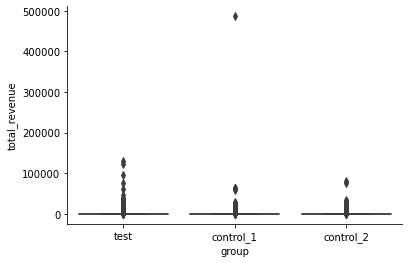

In [21]:
sns.boxplot( x = 'group', y = 'total_revenue', data = users)
sns.despine()

In [22]:
# посмотрим этот явный выброс более подробно

In [23]:
users.query('total_revenue > 400000')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,control_1


In [24]:
# посмотрим на этого пользователя в transactions

In [25]:
transactions.query('uid == 892333905').sort_values('paid_at').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
49,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,control_1
13,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,control_1
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,control_1
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,control_1
28,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,control_1


Пользователь 892333905 совершил очень много покупок за два дня  - причем очень много покупок за короткий промежуток, даже если это не баг(что сомниетльно), для контрольной группы такой пользователь не приемлим.
Удалим его из данных для анализа

In [26]:
transactions_cor = transactions.query('uid != 892333905')
users_cor = users.query('uid != 892333905')

In [27]:
# посмотрим колонку revenue в transactions

In [28]:
transactions.revenue.describe()

count       978.000000
mean       7032.361963
std        8655.787235
min          26.000000
25%        2577.250000
50%        5804.500000
75%        9087.000000
max      113477.000000
Name: revenue, dtype: float64

<AxesSubplot:xlabel='group', ylabel='revenue'>

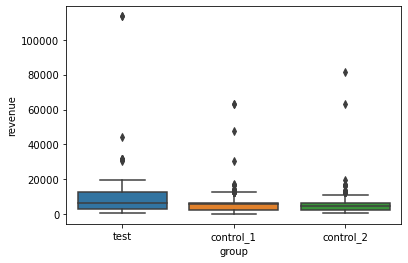

In [29]:
sns.boxplot(data = transactions_cor, x = 'group', y = 'revenue')

In [30]:
# посмотрим выделяющиеся значения - revenue более 20000

In [31]:
transactions_cor.query('revenue > 20000').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
12,891178380.0,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,test
14,892150854.0,Argentina,2017-10-20 00:25:00,2017-10-23 01:31:00,30264.0,68.0,super_popup,other_type,test
44,891346269.0,Argentina,2017-05-11 12:55:00,2017-07-11 11:28:00,31525.0,19.0,empty_likes,coins,test
64,892275462.0,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083.0,19.0,coins_popup,other_type,test
81,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,31525.0,19.0,menu,coins,test


In [32]:
transactions_cor.query('product_type == "premium_no_trial"').revenue.describe()

count       288.000000
mean       7887.975694
std       11932.894520
min        1482.000000
25%        4702.750000
50%        6292.000000
75%        6448.000000
max      113477.000000
Name: revenue, dtype: float64

Есть большие значения по оплате премиум подписки, но их довольно много и они есть во всех группах. Возможно это оплата сразу за большой период - как это соотносится с тем что деньги за подписку списываюся ежемесячно? Видимо все таки можно оплатить за премиум сразу за больший период, чем месяц.

In [33]:
# посмотрим информацию по transactions

In [34]:
transactions_cor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1581 entries, 0 to 327
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           951 non-null    float64       
 1   country       951 non-null    object        
 2   joined_at     951 non-null    datetime64[ns]
 3   paid_at       951 non-null    datetime64[ns]
 4   revenue       951 non-null    float64       
 5   payment_id    951 non-null    float64       
 6   from_page     951 non-null    object        
 7   product_type  951 non-null    object        
 8   group         1581 non-null   object        
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 188.1+ KB


In [35]:
# у нас есть 630 строк польностью пустых  из какой они группы?

In [36]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
group             0
dtype: int64

In [37]:
# они из control_1 - проверим размеры групп control_1 и control_2

In [38]:
transactions_control_1.shape

(1007, 9)

In [39]:
transactions_control_2.shape

(328, 9)

Это явно баг,без этих пропущенных строк, размеры контрольных групп будут сопоставимы
пропущенные значения можно удалять

In [40]:
transactions_cor = transactions_cor.dropna()

In [41]:
# что означают payment_id - индифактор платежа - посмотрим связь данного параметра с другими

In [42]:
transactions_cor \
    .groupby('payment_id',as_index = False) \
    .agg({'product_type':'unique','revenue':sum,'country':'nunique','group':'nunique','from_page':'nunique',
         'uid':'count'})

,payment_id,product_type,revenue,country,group,from_page,uid
0,0.0,"[premium_no_trial, other_type]",27456.0,5,3,5,7
1,19.0,"[coins, other_type]",1214330.0,19,3,10,281
2,67.0,[other_type],295958.0,12,3,8,97
3,68.0,"[premium_no_trial, other_type]",247130.0,11,3,2,46
4,127.0,[other_type],7293.0,1,1,2,5
5,146.0,[coins],301574.0,16,3,5,91
6,147.0,"[trial_premium, premium_no_trial]",4297579.0,21,3,13,424


Кроме того, что некоторые индификаторы платежа относятся только к конкретным продуктам
и то что индификатор есть только в одной стране и в одной группе ( в контрольной группе 1),
здесь интересной информации нет

In [43]:
transactions_cor.query('payment_id == 127')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,control_1
200,891367521.0,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,127.0,coins_popup,other_type,control_1
257,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127.0,sympathy,other_type,control_1
298,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127.0,sympathy,other_type,control_1
308,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127.0,sympathy,other_type,control_1


In [44]:
# посмотрим на самого активного пользователя по количеству покупок

In [45]:
transactions_cor.groupby('uid').agg({'revenue':'count'}).sort_values('revenue', ascending = False).idxmax()

revenue    892236423.0
dtype: float64

In [46]:
# посмотрим временной промежуток регистраций и оплат с которым мы работаем

In [47]:
np.percentile(transactions_cor.joined_at, [0, 100])

array(['2015-01-19T11:49:00.000000000', '2017-10-31T23:40:00.000000000'],
      dtype='datetime64[ns]')

In [48]:
np.percentile(transactions_cor.paid_at, [0, 100])

array(['2016-12-14T16:16:00.000000000', '2017-12-11T23:28:00.000000000'],
      dtype='datetime64[ns]')

Есть большая разница между размахом в датах регистрации и оплат - у нас такой большой период тестирования?

In [49]:
# посмтрим распредление по месяцам в joined_at и paid_at

In [50]:
transactions_cor.joined_at.dt.month.sort_values().value_counts()

10    676
5      78
6      53
2      25
3      23
7      21
8      21
1      20
4      17
9      17
Name: joined_at, dtype: int64

In [51]:
# основная масса в 10 месяц

In [52]:
transactions_cor.paid_at.dt.month.sort_values().value_counts()

10    502
11     96
6      51
5      48
4      43
12     37
7      35
8      32
3      30
9      30
2      29
1      18
Name: paid_at, dtype: int64

In [53]:
# очень много транзакций в 11 день

In [54]:
transactions_cor.paid_at.dt.day.sort_values().value_counts()

11    431
23     53
31     40
22     39
29     38
14     37
25     32
26     30
15     29
13     28
30     28
28     27
20     23
24     23
19     19
27     19
21     16
18     14
16     14
17     11
Name: paid_at, dtype: int64

In [55]:
# распределние по дням

In [56]:
transactions_cor.joined_at.dt.normalize().sort_values().value_counts()

2017-10-21    85
2017-05-11    78
2017-10-18    61
2017-10-29    56
2017-06-11    53
2017-10-22    47
2017-10-30    46
2017-10-15    46
2017-10-26    38
2017-10-23    34
2017-10-20    33
2017-10-31    28
2017-10-24    27
2017-10-16    27
2017-10-19    26
2017-02-11    25
2017-10-25    24
2017-10-17    24
2017-10-14    23
2017-03-11    23
2017-08-11    21
2017-07-11    21
2017-10-28    20
2017-10-27    18
2017-01-11    17
2017-09-11    17
2017-04-11    17
2017-10-11    13
2015-01-19     3
Name: joined_at, dtype: int64

In [57]:
# создадим столбец с месяцем оплаты и посмотрим данные без 10 и 11 месяца
# во всех месяцах кроме 10 и 11  - 11 число, кроме 2016-12-14

In [58]:
transactions_cor['paid_at_month'] = transactions_cor.paid_at.dt.month

In [59]:
list_10_11 = [10,11]
transactions_cor \
    .query('paid_at_month not in @list_10_11') \
    .paid_at.dt.normalize() \
    .sort_values() \
    .value_counts()

2017-06-11    51
2017-05-11    48
2017-04-11    43
2017-07-11    35
2017-12-11    34
2017-08-11    32
2017-03-11    30
2017-09-11    30
2017-02-11    29
2017-01-11    18
2016-12-14     3
Name: paid_at, dtype: int64

В случае 11 чисел это явная ошибка при присваивании даты - месяц перепутали с днем, учитывая что нам 
инетерсны оплаты за весь период, а не по дням, здесь можно ничего не поправлять, а просто указать на
данный факт. В случае даты 2016-12-14 посмотрим попоробнее.

In [60]:
# также посмотрим сразу данные по датам регистраций

In [61]:
transactions_cor['joined_at_month'] = transactions_cor.joined_at.dt.month

In [62]:
transactions_cor \
    .query('joined_at_month not in @list_10_11') \
    .joined_at.dt.normalize() \
    .sort_values() \
    .value_counts()

2017-05-11    78
2017-06-11    53
2017-02-11    25
2017-03-11    23
2017-07-11    21
2017-08-11    21
2017-01-11    17
2017-04-11    17
2017-09-11    17
2015-01-19     3
Name: joined_at, dtype: int64

In [63]:
# сдесь похожая ситуация и есть аномалия с датой 2015-01-19 - ее также рассмотрим поподробнее

In [64]:
transactions_cor.sort_values('joined_at').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,paid_at_month,joined_at_month
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1,12,1
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1,12,1
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1,12,1
368,891561825.0,France,2017-01-11 01:06:00,2017-04-11 23:21:00,3900.0,19.0,empty_likes,coins,control_1,4,1
342,891561825.0,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913.0,146.0,empty_likes,coins,control_1,1,1


In [65]:
transactions_cor \
    .query("joined_at.dt.normalize() == '2015-01-19' or paid_at.dt.normalize() == '2016-12-14'")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,paid_at_month,joined_at_month
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1,12,1
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1,12,1
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1,12,1


Это один и тот же пользователь - удалим его из данных, так как наг период работы - октябрь ноябрь 2017

In [66]:
transactions_cor = transactions_cor.query('uid != 960936960')
users_cor = users_cor.query('uid != 960936960')

Интересный факт по таблице users - есть 111 пользователей, которые имеют премиум, но не пренисли доход в анализируемы период.Во всех группах таких поровну. Тут надо понимать на какую даты считается наличие примиума - информации не хватает.

In [67]:
users_cor.query('total_revenue == 0').is_premium.sum()

111.0

In [68]:
users_cor.query('total_revenue == 0 and is_premium == 1').group.value_counts()

control_2    42
control_1    35
test         34
Name: group, dtype: int64

In [69]:
# проверим сопадает ли выручка в наших датасетах - она немного отличается - на 74347 в пользу 
# датасета с транзакциями, на 1 процент

In [70]:
100*(transactions_cor.revenue.sum() - users_cor.total_revenue.sum())/transactions_cor.revenue.sum()

1.1633962463739222

In [71]:
transactions_cor.revenue.sum() - users_cor.total_revenue.sum()

74347.0

In [72]:
# посмотрим из за кого возникает такая разница, для этого сгруппируем датасет транзакции по пользователям,
# по сумме оплат, объеденим с датасетом юзеров, и оставим только тех пользователей,
# у которых отличается total_revenue 

In [73]:
transactions_cor_rev = transactions_cor.groupby('uid', as_index = False).agg({'revenue':sum})

In [74]:
users_cor \
    .merge(transactions_cor_rev, on = 'uid', how = 'left') \
    .fillna(0) \
    .query('total_revenue != revenue')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,revenue
2070,892275462,31,310,0.0,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,14885,test,58968.0
7676,892355163,40,640,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,0.0,0,control_1,30264.0


Два пользователя - из тестовой и контрольной группы 1, у которыз отличается revenue в датасетах юзеров и транзакций. Учитывая, что информация в датасете транзакций более подробная в плане покупок, а значит и более корректна на мой взгляд - в дальнейшем для анализа покупок будем использовать только информацию
из транзакций

In [75]:
transactions_cor.query('uid in [892275462,892355163]')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,paid_at_month,joined_at_month
64,892275462.0,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083.0,19.0,coins_popup,other_type,test,2,10
154,892275462.0,France,2017-10-17 05:56:00,2017-10-20 17:00:00,14885.0,68.0,super_popup,other_type,test,10,10
303,892355163.0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,control_1,10,10


In [76]:
# проверим дубликаты - они есть во всех группах

In [77]:
transactions_cor.loc[transactions_cor.duplicated()].head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,paid_at_month,joined_at_month
55,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test,10,10
96,892050108.0,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261.0,19.0,empty_likes,coins,test,10,10
127,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test,10,10
158,891508155.0,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936.0,19.0,empty_likes,coins,test,3,2
188,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261.0,19.0,empty_likes,coins,test,10,10


In [78]:
# удалим их

In [79]:
transactions_cor = transactions_cor.drop_duplicates()

In [80]:
# проверим покупали ли подписку (premium_no_trial) несколько раз 

In [81]:
transactions_cor.query('product_type == "premium_no_trial"').shape

(288, 11)

In [82]:
transactions_cor.query('product_type == "premium_no_trial"').uid.nunique()

267

In [83]:
# да покупали - посмотрим на эту информацию более подробно - выделим пользователей с покупками премиум больше 1

In [84]:
uid_several_premium = transactions_cor \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid', as_index = False).agg({'product_type':'count'}) \
    .query('product_type > 1').uid

In [85]:
# и посмотрим на них

In [86]:
transactions_cor \
    .query('uid in @uid_several_premium') \
    .sort_values('uid') \
    .query('product_type == "premium_no_trial"').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,paid_at_month,joined_at_month
138,891216033.0,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292.0,0.0,autoreply_message,premium_no_trial,control_1,7,7
269,891216033.0,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292.0,147.0,autoreply_message,premium_no_trial,control_1,7,7
144,891219540.0,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719.0,147.0,none,premium_no_trial,control_2,7,7
90,891219540.0,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719.0,0.0,none,premium_no_trial,control_2,7,7
351,891264903.0,United States of America,2017-06-11 16:02:00,2017-09-11 10:32:00,3874.0,147.0,none,premium_no_trial,control_1,9,6


In [87]:
transactions_cor.query('payment_id == 0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,paid_at_month,joined_at_month
220,891725043.0,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217.0,0.0,none,premium_no_trial,test,10,10
138,891216033.0,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292.0,0.0,autoreply_message,premium_no_trial,control_1,7,7
347,892101909.0,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,0.0,none,premium_no_trial,control_1,10,10
90,891219540.0,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719.0,0.0,none,premium_no_trial,control_2,7,7


Есть покупки премиума, которые отличаются только payment_id - у дубля он иммеет значение - 0, это очень похоже на баг. Это все покупки с payment_id = 0 - удаляю эти дубли - на мой взгляд это явный баг.

In [88]:
transactions_cor = transactions_cor.query('payment_id != 0')

### Выберем метрики, которые нас интересуют

#### конверсия 

В первую очередь нас инетерсует конверсия в премиум подписку (не триал) - какой процент пользователей купил премиум подписку

In [89]:
# пользователи у которых покупали подписку premium_no_trial (подсчитаем также тех кто купил триал)

In [90]:
uid_with_premium_no_trial = transactions_cor.query('product_type == "premium_no_trial"').uid.unique()

In [91]:
uid_with_trial_premium = transactions_cor.query('product_type == "trial_premium"').uid.unique()

In [92]:
# в датасете юзеров добавим колонки с информацией о таких покупке

In [93]:
users_cor['premium_no_trial'] = users_cor.uid.isin(uid_with_premium_no_trial)
users_cor['trial_premium'] = users_cor.uid.isin(uid_with_trial_premium)

In [94]:
# посмотрим распределение по купившим и не купившим premium_no_trial и конверсию в premium_no_trial

In [95]:
pd.crosstab(users_cor.group, users_cor.premium_no_trial)

premium_no_trial,False,True
group,,
control_1,4240,98
control_2,4162,102
test,4241,67


In [96]:
users_cor.groupby('group').premium_no_trial.mean()

group
control_1    0.022591
control_2    0.023921
test         0.015552
Name: premium_no_trial, dtype: float64

конверсия в любую покупку - скидка на премиум может влять на другие покупки

In [97]:
# добавим в датасет users столбец с revenue из transaction - учитывая что мы удалили дубли из transaction 
# информация об общих покупках в users некорректна 

In [98]:
transactions_cor_revenue = transactions_cor.groupby('uid', as_index = False).agg({'revenue':sum})

In [99]:
users_cor = users_cor.merge(transactions_cor_revenue, on = 'uid', how = 'left').fillna(0)

In [100]:
# создадим столбец с информацией были ди покупки у пользователя или нет

In [101]:
users_cor['purchaser'] = users_cor.revenue != 0

In [102]:
# посмотрим конверсию в покупки

In [103]:
users_cor.groupby('group').purchaser.mean()

group
control_1    0.044030
control_2    0.043856
test         0.033890
Name: purchaser, dtype: float64

Конверсия это хорошо, но нас интересует unit экономика - arpu и arppu, средний доход с пользователя, и средний доход с пользователя совершившего покупку можно посчитать средний чек. Стоит лиосчитать retention ? на мой взляд у нас мало информации для того чтобы решить какой retention.

#### arpu

In [104]:
# посмотрим arpu по группам

In [105]:
users_cor.groupby('group').revenue.mean()

group
control_1    479.064085
control_2    446.359756
test         539.231430
Name: revenue, dtype: float64

In [106]:
# выделим сразу информацию по группам - понадобится в дальнейшем анализе

In [107]:
arpu_test      = users_cor.query('group == "test"').revenue
arpu_control_1 = users_cor.query('group == "control_1"').revenue
arpu_control_2 = users_cor.query('group == "control_2"').revenue

#### arppu

In [108]:
# посмотрим arppu по группам

In [109]:
users_cor.query('revenue != 0').groupby('group').revenue.mean()

group
control_1    10880.523560
control_2    10177.957219
test         15911.020548
Name: revenue, dtype: float64

In [110]:
arppu_test      = users_cor.query('revenue != 0 and group == "test"').revenue
arppu_control_1 = users_cor.query('revenue != 0 and group == "control_1"').revenue
arppu_control_2 = users_cor.query('revenue != 0 and group == "control_2"').revenue

In [111]:
# посмотрим также средний чек и средний чек по группам

In [112]:
transactions_cor['revenue'].sum()/transactions_cor['revenue'].count()

6860.138193688792

In [113]:
transactions_cor.groupby('group', as_index = False).agg({'revenue': lambda x: x.sum()/x.count()})

,group,revenue
0,control_1,6259.578313
1,control_2,5910.801242
2,test,8766.071698


### A-A test

Проведем A-A тест - для этого проверим честность деления пользователей между группами и проверим FPR (долю ложноположительных отметок) с помощью arpu

#### честность деления пользователей между группами

In [114]:
# по возрасту
users_cor.groupby('group', as_index = False).agg({'age':'describe'})

group     age                                                    
               count       mean        std   min   25%   50%   75%   max
0  control_1  4338.0  32.098202  10.258636  16.0  24.0  30.0  38.0  99.0
1  control_2  4264.0  32.046201  10.170721  16.0  25.0  30.0  38.0  99.0
2       test  4308.0  31.889276  10.245287  16.0  25.0  30.0  38.0  99.0

In [115]:
# по коэфициенту привлекательности
users_cor.groupby('group', as_index = False).agg({'attraction_coeff':'describe'})

group attraction_coeff                                           \
                        count        mean         std  min  25%    50%   
0  control_1           4338.0  312.151452  321.005290  0.0  0.0  239.0   
1  control_2           4264.0  317.957317  326.191737  0.0  0.0  250.0   
2       test           4308.0  316.411328  323.373725  0.0  0.0  250.0   

                   
      75%     max  
0  518.00  1000.0  
1  548.50  1000.0  
2  520.25  1000.0

In [116]:
# по странам
users_cor.groupby(['country','group'], as_index = False).agg({'uid':'count'}) \
    .pivot(index='country', columns='group', values='uid') \
    .sort_values('test', ascending = False)

group,control_1,control_2,test
country,,,
United States of America,1471.0,1486.0,1450.0
Argentina,389.0,397.0,396.0
France,370.0,376.0,359.0
Italy,337.0,293.0,323.0
Spain,342.0,310.0,301.0
...,...,...,...
Qatar,1.0,1.0,NaN
Somalia,NaN,1.0,NaN
Sweden,1.0,NaN,NaN


In [117]:
# по нижней границе запроса возраста
users_cor.groupby('group', as_index = False).agg({'age_filter_start':'describe'})

group age_filter_start                                               \
                        count       mean       std   min   25%   50%   75%   
0  control_1           4338.0  26.795758  9.406519  13.0  19.0  25.0  32.0   
1  control_2           4264.0  26.954268  9.546657  13.0  19.0  25.0  32.0   
2       test           4308.0  26.701486  9.390851  13.0  19.0  24.0  32.0   

         
    max  
0  96.0  
1  94.0  
2  96.0

In [118]:
# по верхней границе запроса возраста
users_cor.groupby('group', as_index = False).agg({'age_filter_end':'describe'})

group age_filter_end                                                \
                      count       mean        std   min   25%   50%   75%   
0  control_1         4338.0  38.550945  15.224909  19.0  28.0  35.0  45.0   
1  control_2         4264.0  38.906895  15.955574  19.0  28.0  35.0  45.0   
2       test         4308.0  38.248839  15.344562  19.0  28.0  35.0  44.0   

          
     max  
0  102.0  
1   99.0  
2  102.0

In [119]:
# посмотрим по дням возврата

In [120]:
users_cor['sum_visit_days'] = users_cor.visit_days.apply(lambda x: len(x.split(',')) if x != 'no' else 0)

In [121]:
users_cor.groupby('group').sum_visit_days.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control_1,4338.0,4.636468,6.305418,0.0,0.0,2.0,7.0,31.0
control_2,4264.0,4.446060,6.173760,0.0,0.0,2.0,6.0,31.0
test,4308.0,4.585422,6.185875,0.0,0.0,2.0,7.0,31.0


В итоге распределние по группам достаточно равномерное, без аномалий

#### проверим FPR с помощью arpu

In [122]:
# проверим на гомогенность дисперсий , H0 - дисперсии гомогенны

In [123]:
st.levene(arpu_control_1,arpu_control_2)

LeveneResult(statistic=0.264043864131449, pvalue=0.6073686801682943)

In [124]:
# pvalue значительно выше 0.05 - гипотеза о гомогенности дисперсий не отклоняется

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

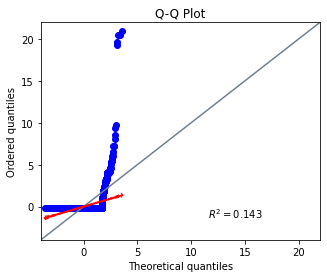

In [125]:
# посмотрим насколько нормальное распределение - на qqplote и histplot
pg.qqplot(arpu_control_1)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

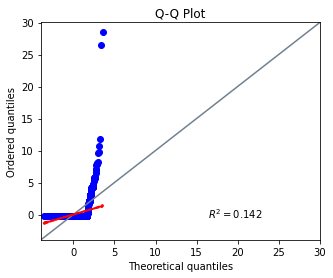

In [126]:
pg.qqplot(arpu_control_2)

<AxesSubplot:xlabel='revenue', ylabel='Count'>

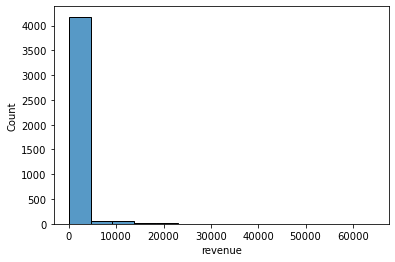

In [127]:
sns.histplot(arpu_control_1)

Распреление далеко от нормального, но выборки большие, так что проверим t-testom

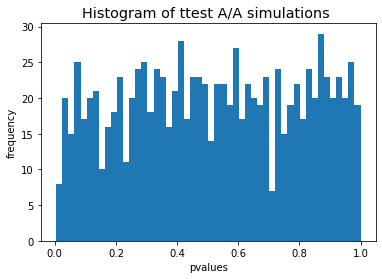

0.032

In [128]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in range(simulations):
    s1 = users_cor[users_cor.group == 'control_1']['revenue'].sample(n_s, replace = False).values
    s2 = users_cor[users_cor.group == 'control_2']['revenue'].sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

FPR < 0.05 - сплитовалка работает корректно

Проверим распределения на всякий случай через манна уитни (arpu ты таким образом не проверим, но проверим что распределение признака (revenue) в первой выборке соответствует распределению признака во второй выборке)

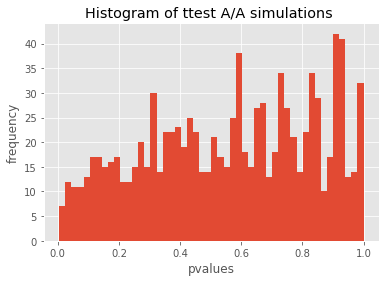

0.022

In [129]:
simulations = 1000
n_s = 1000
res = []
for i in range(simulations):
    s1 = users_cor[users_cor.group == 'control_1']['revenue'].sample(n_s, replace = False).values
    s2 = users_cor[users_cor.group == 'control_2']['revenue'].sample(n_s, replace = False).values
    res.append(st.mannwhitneyu(s1, s2)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

FPR < 0.05 - сплитовалка работает корректно

### A-B тестирование

#### arpu

In [130]:
# сравним изменение в arpu  - изменилась ли прибыль с пользователя?

In [131]:
# проверим гомогенность дисперсий, H0 - дисперсии гомогенны

In [132]:
st.levene(arpu_test,arpu_control_1)

LeveneResult(statistic=0.5455590139624976, pvalue=0.46015803156975277)

In [133]:
# HO гипотеза не отклоняется, диспресии гомогенны

Насколько помним из A - А теста есть вопросы к нормлаьности распределния arpu, поэтому в данном случае воспользуемся Бутстрапом (нет такой нагрузки по итерациям как в A-A тесте)

In [134]:
# добавим функцию бутстрапа

In [135]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean, 
    bootstrap_conf_level = 0.95
):
    """
    Возвращает 'p_value', 'ci' - доверительный интервал,'boot_data'- статистику разницы на каждой иттерации.
    :param data_column_1: числовые значения первой выборки
    :param data_column_1: числовые значения второй выборки
    :param boot_it: количество бутстрэп-подвыборок, по умолчанию 1000 
    :param statistic: интересующая нас статистика, по умолчанию mean
    :param bootstrap_conf_level: уровень значимости, по умолчанию 0.95

    """
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample( boot_len, replace = True).values
        
        samples_2 = data_column_2.sample( boot_len, replace = True).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_value = min(sum(pd_boot_data[0] < 0), sum(pd_boot_data[0] > 0)) * 2 / len(pd_boot_data[0])
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [136]:
help(get_bootstrap)

Help on function get_bootstrap in module __main__:

get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=<function mean at 0x7f87c303fd30>, bootstrap_conf_level=0.95)
    Возвращает 'p_value', 'ci' - доверительный интервал,'boot_data'- статистику разницы на каждой иттерации.
    :param data_column_1: числовые значения первой выборки
    :param data_column_1: числовые значения второй выборки
    :param boot_it: количество бутстрэп-подвыборок, по умолчанию 1000 
    :param statistic: интересующая нас статистика, по умолчанию mean
    :param bootstrap_conf_level: уровень значимости, по умолчанию 0.95



Проверим гипотезу о разности средних бустрапом:
1. H0 гипотеза - средние выборок стат.значимо не отличаются
2. H1 - средние стат.значимо отличаюся

  0%|          | 0/1000 [00:00<?, ?it/s]

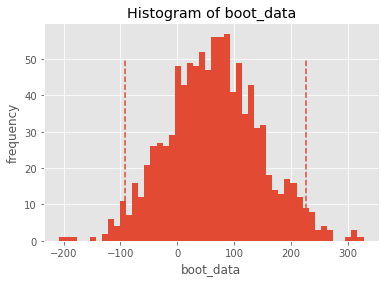

In [137]:
arpu_1 = get_bootstrap(arpu_test,arpu_control_1,statistic = np.mean)

In [138]:
arpu_1['p_value']

0.43

In [139]:
arpu_1["ci"]

,0
0.025,-91.907198
0.975,227.532590


  0%|          | 0/1000 [00:00<?, ?it/s]

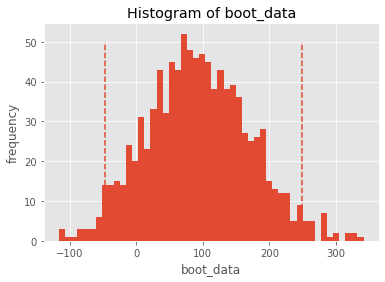

In [140]:
arpu_2 = get_bootstrap(arpu_test,arpu_control_2,statistic = np.mean)

In [141]:
arpu_2['p_value']

0.228

In [142]:
arpu_2["ci"]

,0
0.025,-47.416504
0.975,249.557602


In [143]:
if arpu_1['p_value'] > 0.05:
    print('H0 гипотеза о том что средние не отличаются, не отклоняется')
else: print('H0 гипотеза о том что средние не отличаются, отклоняется')

H0 гипотеза о том что средние не отличаются, не отклоняется


In [144]:
# посмотрим на всякий случай какие результаты дает t-test

In [145]:
st.ttest_ind(arpu_test,arpu_control_1)

Ttest_indResult(statistic=0.7386196680041072, pvalue=0.46015803157161606)

In [146]:
st.ttest_ind(arpu_test,arpu_control_2)

Ttest_indResult(statistic=1.1580726915361812, pvalue=0.24686664502584993)

In [147]:
# t-test выдает похожие результаты

Статистически значимых различий в ARPU не обнаружено

#### arppu

In [148]:
# Cравним изменение в ARPPU  - изменилась ли прибыль с платящего пользователя?

In [149]:
# проверим гомогенность дисперсий, H0 - дисперсии гомогенны

In [150]:
st.levene(arppu_test,arppu_control_1)

LeveneResult(statistic=4.918069769875995, pvalue=0.027247716386937706)

In [151]:
# p_value < 0.05 HO гипотеза отклоняется, дисперсии не гомогенны

In [152]:
# посмотрим боксплот

<AxesSubplot:xlabel='group', ylabel='revenue'>

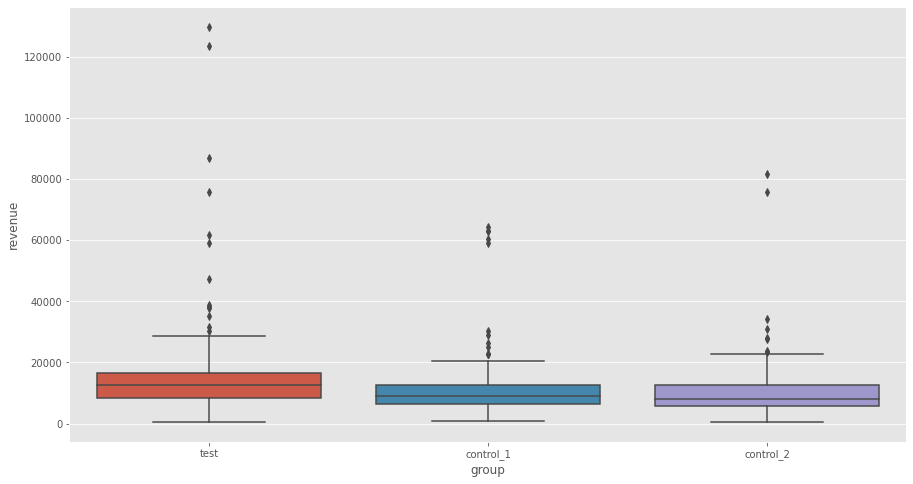

In [153]:
plt.figure(figsize=(15,8))
sns.boxplot(data = users_cor.query('revenue > 0') , x = 'group', y = 'revenue')

In [154]:
# есть много выбросов

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

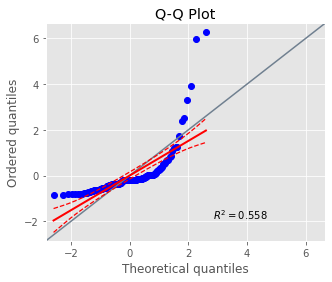

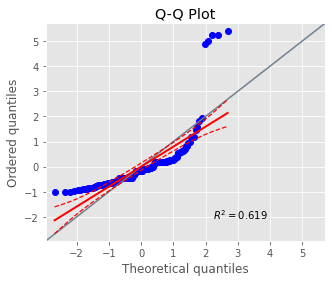

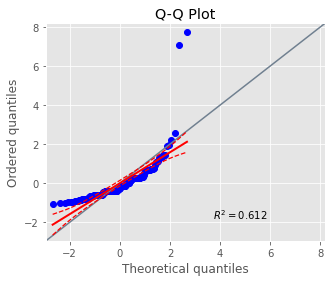

In [155]:
# Посмотрим QQ plot
pg.qqplot(arppu_test)
pg.qqplot(arppu_control_1)
pg.qqplot(arppu_control_2)

Распределния не нормально

Проверим гипотезу о разности средних бустрапом:
1. HO гипотеза - средние выборок стат.значимо не отличаются
2. H1 - средние стат.значимо отличаюся

  0%|          | 0/1000 [00:00<?, ?it/s]

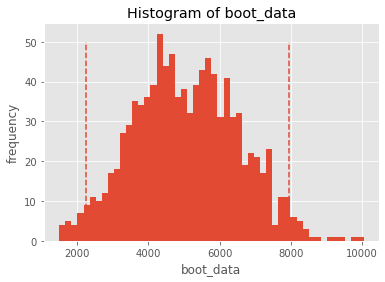

In [156]:
arppu_boot_1 = get_bootstrap(arppu_test,arppu_control_1,statistic = np.mean)

In [157]:
arppu_boot_1['p_value']

0.0

  0%|          | 0/1000 [00:00<?, ?it/s]

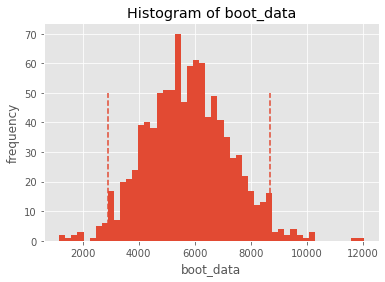

In [158]:
arppu_boot_2 = get_bootstrap(arppu_test,arppu_control_2,statistic = np.mean)

In [159]:
arppu_boot_2['p_value']

0.0

P-value < 0.05, H0 гипотеза отклоняется, средние статистически значимо отличаются

In [160]:
# Welch’s t-test нам выдает тот же результат

In [161]:
st.ttest_ind(arppu_test,arppu_control_1,equal_var=False)

Ttest_indResult(statistic=3.0176330923125416, pvalue=0.00286174302219838)

In [162]:
st.ttest_ind(arppu_test,arppu_control_2,equal_var=False)

Ttest_indResult(statistic=3.4751078874493047, pvalue=0.0006240521787390326)

Обнаружены статистически значимые различия в ARRPU между тестовой и контрольными группами

#### конверсия

Проверим конверсию в покупку премиума и вообще в любую покупку

В данном случае у нас номитнативные переменные - воспользуемся методом Xu - квадратом:
1. H0 - частоты согласованы, фактические данные не противоречат ожидаемым
2. H1 - отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы


In [163]:
# для этого сделаем необходимый датасет

In [164]:
conv_prem = pd.crosstab(users_cor.premium_no_trial,users_cor.group)
conv_prem

group,control_1,control_2,test
premium_no_trial,,,
False,4240,4162,4241
True,98,102,67


In [165]:
stat, p, dof, expected = st.chi2_contingency(conv_prem)

In [166]:
p

0.013663109149335195

Отклоняем нулевую гипотезу, расхождения статистически значимы в покупке премиума

In [167]:
users_cor.groupby('group').premium_no_trial.mean()

group
control_1    0.022591
control_2    0.023921
test         0.015552
Name: premium_no_trial, dtype: float64

В тестовой группе конверсия в премиум значимо ниже

In [168]:
# проведем похожую проверку для конверсии в любую покупку

In [169]:
conv_purch = pd.crosstab(users_cor.purchaser,users_cor.group)
conv_purch

group,control_1,control_2,test
purchaser,,,
False,4147,4077,4162
True,191,187,146


In [170]:
stat, p, dof, expected = st.chi2_contingency(conv_purch)

In [171]:
p

0.02410129962606572

Отклоняем нулевую гипотезу, расхождения статистически значимы в покупке

In [172]:
users_cor.groupby('group').purchaser.mean()

group
control_1    0.044030
control_2    0.043856
test         0.033890
Name: purchaser, dtype: float64

В тестовой группе конверсия в покупку значимо ниже

In [173]:
# есть ли изменения в конверсии в триал-премиум, который не изменился в цене?

In [174]:
conv_trial = pd.crosstab(users_cor.trial_premium,users_cor.group)
conv_trial

group,control_1,control_2,test
trial_premium,,,
False,4271,4211,4247
True,67,53,61


In [175]:
stat, p, dof, expected = st.chi2_contingency(conv_trial)

In [176]:
p

0.4908102300892675

В конверсии в покупки триал-премиума, значимых различий нет

В итоге у нас, в тестовой группе значимое уменьшение конверсии в премиум, но при этом есть значимое увеличение ARPPU и как итог ARPU значимо не изменился.

Предварительный вывод говорит, что разворачивать обновление на всю группу не имеет смысла. Проверим имеет ли смысл нововедение среди конкретных подгрупп пользователей

### Разделение пользователей на группы и тестирование на отдельных группах

Буду делить переменные которые на мой взгляд могут влиять на целевое действие (покупка премиума) на погруппы,
смотреть конверсию, проверять стат. значимость в различии конверсии между тестовой и контрольной группами в рамках
подгрупп. Если какие то подгруппы выделяются от общей тенденции, также буду смотреть разницу в arpu.

#### Начнем с возраста

In [177]:
# посмотрим распределение по возрасту

<AxesSubplot:xlabel='age', ylabel='Count'>

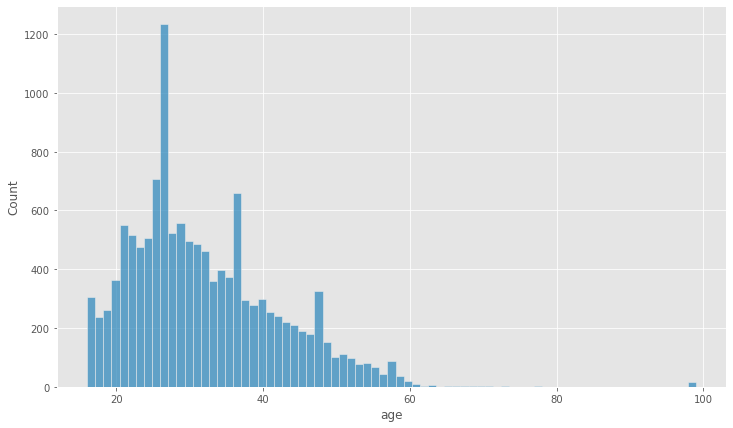

In [178]:
plt.figure(figsize=(12, 7))
sns.histplot(users_cor.age)

В основном все до 60 лет, свыше 60 лет очень мало пользователей, их брать в расчет не будем

In [179]:
# будет ли заметна, какая то корреляция между возрастом и конверсией в премиум?

In [180]:
age_corr_control = users_cor \
    .query('group != "test" and age < 60') \
    .groupby('age') \
    .agg({'premium_no_trial':'mean'})

In [181]:
# в контрольные группы

<AxesSubplot:xlabel='age', ylabel='premium_no_trial'>

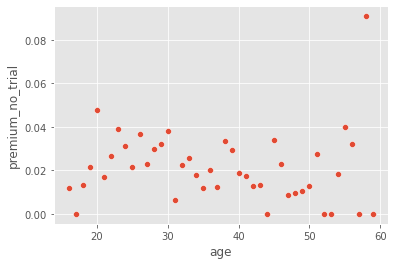

In [182]:
sns.scatterplot(x = 'age', y = 'premium_no_trial', data = age_corr_control)

In [183]:
age_corr_test = users_cor \
    .query("group == 'test' and age < 60") \
    .groupby('age', as_index = False).agg({'premium_no_trial':'mean'})

In [184]:
# в тестовой группе

<AxesSubplot:xlabel='age', ylabel='premium_no_trial'>

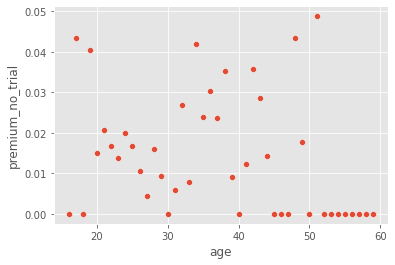

In [185]:
sns.scatterplot(x = 'age', y = 'premium_no_trial', data = age_corr_test)

Как мы уже раннее проверяли, распределение по возрасту в группах не отличается, заметно что, в возрасте от 50 лет в тестовой группе практически нет покупок ремиума и есть просадка, в отличии от контрольной группы, в возрасте 20-30 лет

In [186]:
# на первый взгляд другой тенденции нет, разделим людей по группам которые мы определили - до 20 лет, 
# от 20 до 30, от 30 до 50, и старше

In [187]:
users_cor['age_cut'] = pd.cut(users_cor.age, bins = [0,20,30,50,110], 
                              labels = ['young', 'mature_1', 'mature_2', 'old'])

In [188]:
# посмотрим конверсию в премиум для разных возрастных категорий

In [189]:
users_cor \
    .groupby(['age_cut','group'], as_index = False) \
    .agg({'premium_no_trial':'mean'}) \
    .pivot(index = 'group', columns = 'age_cut', values = 'premium_no_trial')

age_cut,young,mature_1,mature_2,old
group,,,,
control_1,0.020672,0.028633,0.016516,0.026906
control_2,0.029024,0.029428,0.018262,0.016461
test,0.014963,0.012807,0.018857,0.013043


В группе mature_2 есть заметное отличии по конверсии - конверсия в тестовой группе не падает

In [190]:
# проверим Xu квадратом статистические различия в группе mature_2

In [191]:
mature_2_conv = pd.crosstab(users_cor.query("age_cut == 'mature_2'").premium_no_trial,
            users_cor.query("age_cut == 'mature_2'").group)
mature_2_conv

group,control_1,control_2,test
premium_no_trial,,,
False,1846,1774,1769
True,31,33,34


In [192]:
stat, p, dof, expected = st.chi2_contingency(mature_2_conv)

In [193]:
p

0.8554292334282154

В отличии от общей тенденции на уменьшение конверсии, в подгруппе mature_2 статистических различий не найдено

In [194]:
# проверим arpu в данной подгруппе

In [195]:
arpu_test_mature_2      = users_cor.query('group == "test" and age_cut == "mature_2"').revenue
arpu_control_2_mature_2 = users_cor.query('group == "control_2" and age_cut == "mature_2"').revenue

In [196]:
# проверим бутстрапом - со второй контрольной группой, у котороый выше конверсия и arpu

  0%|          | 0/1000 [00:00<?, ?it/s]

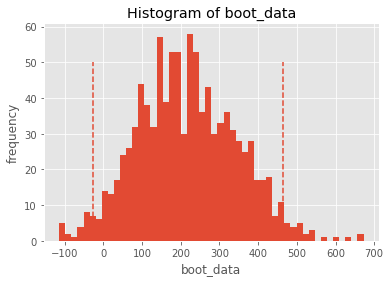

In [197]:
arpu_mature_2 = get_bootstrap(arpu_test_mature_2,arpu_control_2_mature_2)

In [198]:
arpu_mature_2['p_value']

0.07

In [199]:
arpu_mature_2['ci']

,0
0.025,-27.336511
0.975,464.471403


p_value > 0.05 - статистически значимых различий в arpu нет

В итоге есть несколько возрастных групп, в которых есть спад в конверсии в премиум, в ворасте от 20 до 30 лет,
и в возрасте от 50 до 60 лет. В возрасте от 30 до 50 вопреки общей тенденции, снижения в конверсии не обнаружено, но при этом нет значимого увеличение в arpu.
Возможно разные категории людей по возрасту, по разному реагируют на нововедение. Тут неплохо бы понимать в каких 
платежных системах проихошло изменение.

#### группы по полу

Насколько мы помним, у нас в приложении в основном мужчины и они дают тенденцию. Посмотрим соблюдается ли тенденция ( уменьшение конверсии ) у женщин.

In [200]:
users_women = users_cor.query("gender == 0")

In [201]:
users_women.groupby('group').premium_no_trial.mean()

group
control_1    0.000000
control_2    0.025641
test         0.000000
Name: premium_no_trial, dtype: float64

In [202]:
users_women.query('premium_no_trial == True')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,premium_no_trial,trial_premium,revenue,purchaser,sum_visit_days,age_cut
8795,891291573,37,382,0.0,United States of America,"1,2,3",0,34,40,471,1.0,1.0,6292,control_2,True,False,6292.0,True,3,mature_2
8871,892032072,26,0,0.0,United Kingdom (Great Britain),"1,2,3",0,16,99,16157,1.0,0.0,3588,control_2,True,False,3588.0,True,3,mature_1
10342,892333464,34,316,0.0,United States of America,1,0,31,37,698,1.0,1.0,4537,control_2,True,False,4537.0,True,1,mature_2
12557,891170697,35,664,0.0,United Kingdom (Great Britain),"1,2",0,30,71,542,1.0,1.0,4693,control_2,True,False,4693.0,True,2,mature_2
12797,891826944,36,43,0.0,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",0,27,33,1317,1.0,1.0,6292,control_2,True,False,6292.0,True,19,mature_2


Женщин купивших премимум было всего 5 и все из контрольной выборки, анализировать тут нечего

#### attraction_coeff - коэффициент привлекательности

In [203]:
#  посмотрим распределение

<AxesSubplot:xlabel='attraction_coeff', ylabel='Count'>

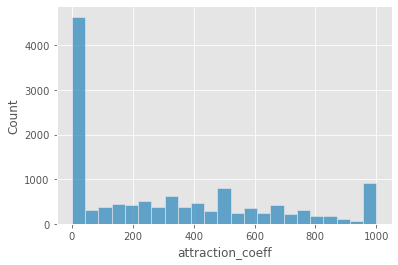

In [204]:
sns.histplot(users_cor.attraction_coeff)

In [205]:
# разделим на 4 группы - 0 , (0:500], (500:999], 1000

In [206]:
users_cor['attraction_сut'] = pd.cut(users_cor.attraction_coeff, bins = [ -1,0,500,999, 1000],
      labels = ['no', 'less', 'more', 'top'])

In [207]:
# посмотрим конверсию для всех подгрупп

In [208]:
attraction_сut_conv = users_cor \
    .groupby(['attraction_сut','group'], as_index = False) \
    .agg({'premium_no_trial':'mean'}) \
    .pivot(index = 'attraction_сut', columns = 'group', values = 'premium_no_trial')
attraction_сut_conv

group,control_1,control_2,test
attraction_сut,,,
no,0.004630,0.003950,0.001334
less,0.038953,0.044554,0.028605
more,0.022222,0.024450,0.020000
top,0.020270,0.012862,0.000000


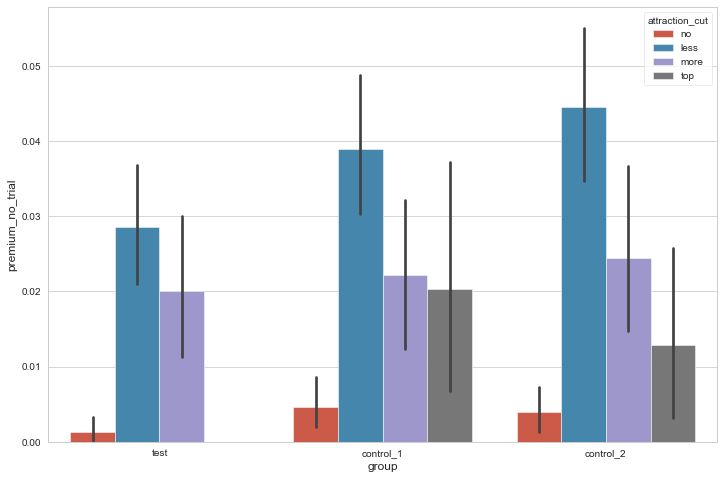

In [209]:
plt.figure(figsize=(12,8))
#sns.set_style('whitegrid')
sns.barplot(x = 'group', y = 'premium_no_trial', hue = 'attraction_сut', data = users_cor)
plt.legend(title = 'attraction_сut')

Нет тендеции, что при малом коэф. привлекательности, пользователь чаще покупает премиум и наоборот, заметное снижение конверсии у группы с нулевой и top привлекательностью.

In [210]:
# посмотрим изменение в конверсии в группе с привлекательностью от 500 до 999

In [211]:
more_conv = pd.crosstab(users_cor.query('attraction_сut == "more"').premium_no_trial,
            users_cor.query('attraction_сut == "more"').group)
more_conv

group,control_1,control_2,test
premium_no_trial,,,
False,792,798,784
True,18,20,16


In [212]:
stat, p, dof, expected = st.chi2_contingency(more_conv)
p

0.8318095448872187

В отличии от общей тенденции на уменьшение конверсии, в данной группе статистических различий не зафиксированo

In [213]:
# проверим arpu у этой подгруппы

In [214]:
arpu_test_more      = users_cor.query('group == "test" and attraction_сut == "more"').revenue
arpu_control_2_more = users_cor.query('group == "control_2" and attraction_сut == "more"').revenue

In [215]:
# проверим бутстрапом - со второй контрольной группой

  0%|          | 0/1000 [00:00<?, ?it/s]

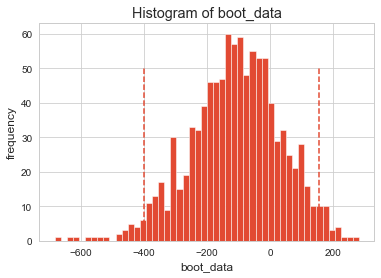

In [216]:
arpu_mature_2 = get_bootstrap(arpu_test_more,arpu_control_2_more)

In [217]:
arpu_mature_2['p_value']

0.432

p_value > 0.05 - статистически значимых различия в arpu нет

#### группы по странам

In [218]:
users_cor.country.value_counts().head(10)

United States of America          4407
Argentina                         1182
France                            1105
Spain                              953
Italy                              953
Chile                              845
United Arab Emirates               644
Germany                            599
United Kingdom (Great Britain)     461
Canada                             405
Name: country, dtype: int64

In [219]:
# возьмем топ 10 стран по количеству премиум подписок

In [220]:
country_top = users_cor \
    .groupby('country', as_index = False) \
    .agg({'premium_no_trial':'sum'}) \
    .sort_values('premium_no_trial') \
    .tail(10).country

In [221]:
# посмотрим для них конверси в премиум

In [222]:
users_cor.query('country in @country_top') \
    .groupby(['country','group'], as_index = False) \
    .agg({'premium_no_trial':'mean'}) \
    .pivot(index = 'country', columns = 'group', values = 'premium_no_trial')

group,control_1,control_2,test
country,,,
Argentina,0.012853,0.017632,0.012626
Chile,0.013937,0.020979,0.014706
France,0.032432,0.021277,0.011142
Germany,0.021277,0.014851,0.009569
Israel,0.091743,0.025641,0.018868
Italy,0.035608,0.013652,0.021672
Spain,0.014620,0.032258,0.019934
United Arab Emirates,0.014493,0.018957,0.026549
United Kingdom (Great Britain),0.027397,0.061644,0.029586


По некоторой части стран выборки не очень большие, в итоге есть разница и между контрольномы группами

In [223]:
# посмотрим также распределение arpu
users_cor.query('country in @country_top') \
    .groupby(['country','group'], as_index = False) \
    .agg({'revenue':'mean'}) \
    .pivot(index = 'country', columns = 'group', values = 'revenue')

group,control_1,control_2,test
country,,,
Argentina,368.712082,304.828715,474.795455
Chile,339.947735,379.772727,257.132353
France,474.078378,396.465426,829.247911
Germany,127.648936,353.509901,459.789474
Israel,1051.449541,867.500000,882.528302
Italy,405.584570,393.771331,351.160991
Spain,289.649123,625.090323,948.265781
United Arab Emirates,364.942029,555.180095,905.168142
United Kingdom (Great Britain),1362.773973,660.773973,457.846154


Посмотрим поближе Spain, United Arab Emirates и France

In [224]:
# Проведем Xu -квадрат для всех

In [225]:
country_int = ['Spain', 'United Arab Emirates', 'France']

In [226]:
p_chi2 = []
for c in country_int:
    value = users_cor.query("country == @c")
    stat, p, dof, expected = st.chi2_contingency(pd.crosstab(value.premium_no_trial, value.group))
    p_chi2.append(p)
p_chi2_country = pd.DataFrame({'country': country_int, 'p_value': p_chi2})

In [227]:
p_chi2_country

,country,p_value
0,Spain,0.295573
1,United Arab Emirates,0.664344
2,France,0.142820


В отличии от общей тенденции на уменьшение конверсии, в данной группе статистических различий не зафиксированo. Проверим их arpu.

In [228]:
# проверим arpu

  0%|          | 0/1000 [00:00<?, ?it/s]

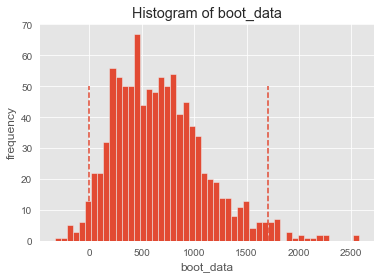

  0%|          | 0/1000 [00:00<?, ?it/s]

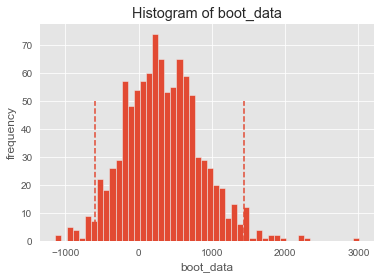

  0%|          | 0/1000 [00:00<?, ?it/s]

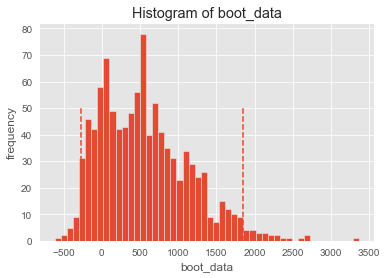

  0%|          | 0/1000 [00:00<?, ?it/s]

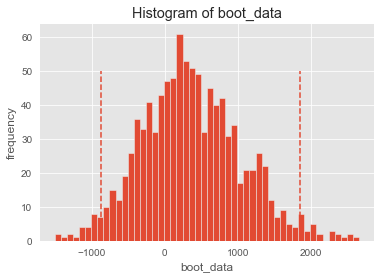

  0%|          | 0/1000 [00:00<?, ?it/s]

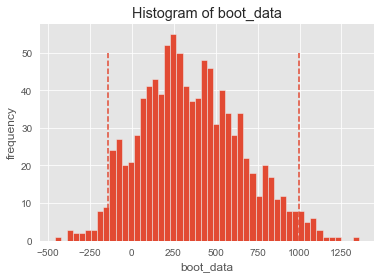

  0%|          | 0/1000 [00:00<?, ?it/s]

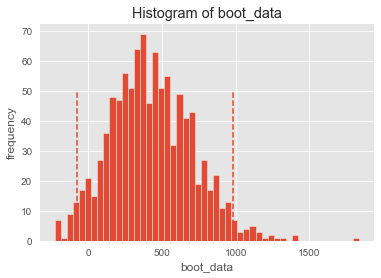

In [229]:
p_v_1 = []
p_v_2 = []
for c in country_int:
    test = users_cor.query("country == @c and group == 'test'")
    control_1 = users_cor.query("country == @c and group == 'control_1'")
    control_2 = users_cor.query("country == @c and group == 'control_2'")
    boot_1 = get_bootstrap(test.revenue, control_1.revenue)
    boot_2 = get_bootstrap(test.revenue, control_2.revenue)
    p_v_1.append(boot_1['p_value'])
    p_v_2.append(boot_2['p_value'])
boot_coutry = pd.DataFrame({'country': country_int, 'p_value_1': p_v_1, 'p_value_2': p_v_2})

In [230]:
boot_coutry

,country,p_value_1,p_value_2
0,Spain,0.054,0.552
1,United Arab Emirates,0.364,0.596
2,France,0.236,0.108


p_value больше 0.05 значимых различий между странами не обнаружено

Есть страны в которых конверсия в премиум в тестовой группе не снизилась, но стран с статистиски значимым повышением arpu не найдено.

#### was_premium

In [231]:
users_cor.groupby(['was_premium','group'], as_index = False).agg({'premium_no_trial':'mean'})

,was_premium,group,premium_no_trial
0,0.0,control_1,0.000000
1,0.0,control_2,0.000000
2,0.0,test,0.000000
3,1.0,control_1,0.225806
4,1.0,control_2,0.248175
5,1.0,test,0.164216


Если was_premium это информация о том, был ли когда нибуль премиум у пользователей, до нашего теста, то здесь
нововедение никак не повлияло на тех у кого не было раньше премиума (они не стали его покупать). Нужно больше
информации по was_premium, чтобы проанализировать.

#### Возможно есть изменения в более узких группах

In [232]:
# в подгруппе в возрасте от 30 до 50 с привлкательностью от 1 до 999

In [233]:
users_cor.query("attraction_сut in ['more','less'] and age_cut == 'mature_2'").group.value_counts()

control_1    1168
test         1164
control_2    1089
Name: group, dtype: int64

In [234]:
users_a_a = users_cor \
    .query("attraction_сut in ['more','less'] and age_cut == 'mature_2'")

In [235]:
# конверсия в премиум

In [236]:
users_a_a.groupby('group').premium_no_trial.mean()

group
control_1    0.023973
control_2    0.029385
test         0.028351
Name: premium_no_trial, dtype: float64

In [237]:
#  arpu

In [238]:
users_a_a.groupby('group').revenue.mean()

group
control_1     603.398116
control_2     664.122130
test         1000.508591
Name: revenue, dtype: float64

  0%|          | 0/1000 [00:00<?, ?it/s]

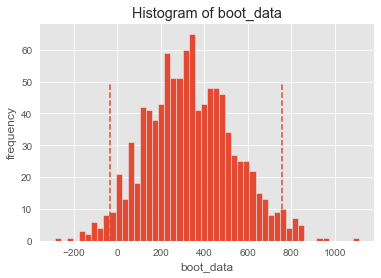

In [239]:
arpu_a_a2 = get_bootstrap(users_a_a.query('group == "test"').revenue, 
                         users_a_a.query('group == "control_2"').revenue)

In [240]:
arpu_a_a2['p_value']

0.08

Стастически значимых различий в arpu не обнаружено

При более узких подгруппах, появляются различия в контрольных группах, и разница с тестовой группой может быть некорректна

## Итог

Был проведен анализ результатов А/А/В тестирования дейтирингового приложения (одна тестовая и 2 контрольных группы), за период октябрь, ноябрь 2017 года.

При первоначальной обработке данных:
1. Убрал дубликаты из всех датасетов и строки с нулевыми значеними контрольной группы 1
2. Убрал 2 пользователей  - один с очень большими повторяющимися покупками, второй в датой вне рассматриваемого периода
3. Убрал дубликаты покупок премиумом, попавших в группу с payment_id = 0
4. Выявил несоответствия информации у 2 пользователей о покупках в а датасетах users и transaction
5. Выявил неправильные даты (в некоторых датах регистрации и покупки перепутаны местами месяц и день)

Провел А/А тестирование получившихся контрольных групп, которое показало корректность спливания.

Провел анализ A/B тестированиы по трем метрикам:
1. конверсия в премиум и конверсия в покупку в тестовой группе статистически значимо упали
2. ARPPU в тестовой группе статистически значимо поднялся
3. ARPU в тестовой группе статистически не изменился

Провел анализ конверсии в премиум и arpu - для подгрупп: по странам, по возрасту, по привлекательности, по полу:
1. Были выявленны подгруппы в которых конверсия в премиум значимо не упала (возраст от 30 до 50, пользователи с привлекательность от 500 до 999, страны Spain, United Arab Emirates и France), но ни для какой из этих групп не было выявлено увеличения в ARPU.
2. Были выявлены подгруппы в которых очень сильно упала конверсия в тестовой группе. Данные подгруппы хуже отриагирвали на нововедение чем остальные - пользователи с нулевой и максимальной привлекательностью, польхователи в возрасте от 20 до 30 и от 50 до 60 лет

## Вывод

1. В целом эксперемент по изменению стоимости премиум-подписки при покупке через две новые платежные системы был скорее не успешен. В тестовой группе был рост ARPPU, что говорит об изменение поведения покупателей, но упала конверсия в премиум подписки. Как итог - доход с пользователя не изменился. И если нужно простое итоговое мнение, то внедрять нововедение не стоит.
2. Но в любом случае изменения поменяли поведение пользователей. Значимо различалось поведение пользователей разных возрастов, а также с разной привлекательностью. При первичном анализе, возрастной подгруппы со значимым повышением arpu не выявили, но у разных возрастов была разная реакция на нововедение, что можно принять во внимание, если будет тестироватся нововедение в похожем направлении.
3. Возможно более подробная информация по тому какие способы оплаты поменялись, и понимание сути колонок was_premium и is_premium дали бы более глубокий анализ с моей стороны